In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck18
from scipy.spatial import cKDTree

In [6]:
def apply_redshift_space_distortions(df, velocity_dispersion=300):
    '''This function adds line-of-sight peculiar velocities to galaxy redshifts.'''
    c = 3e5
    v_peculiar = np.random.normal(0, velocity_dispersion, len(df))
    delta_z = (v_peculiar / c) * (1 + df['z'].values)
    z_obs = df['z'].values + delta_z

    dist_rsd = Planck18.comoving_distance(z_obs).value

    coords = SkyCoord(ra=df['ra'].values * u.deg,
                      dec=df['dec'].values * u.deg,
                      distance=dist_rsd * u.Mpc)
    x_rsd = coords.cartesian.x.value
    y_rsd = coords.cartesian.y.value
    z_rsd = coords.cartesian.z.value
    
    return x_rsd, y_rsd, z_rsd

In [7]:
def count_pairs(data1, data2, bins):
    tree1 = cKDTree(data1)
    counts = np.zeros(len(bins) - 1)

    for i in range(len(bins) - 1):
        counts[i] = tree1.count_neighbors(cKDTree(data2), bins[i+1]) - tree1.count_neighbors(cKDTree(data2), bins[i])

    return counts

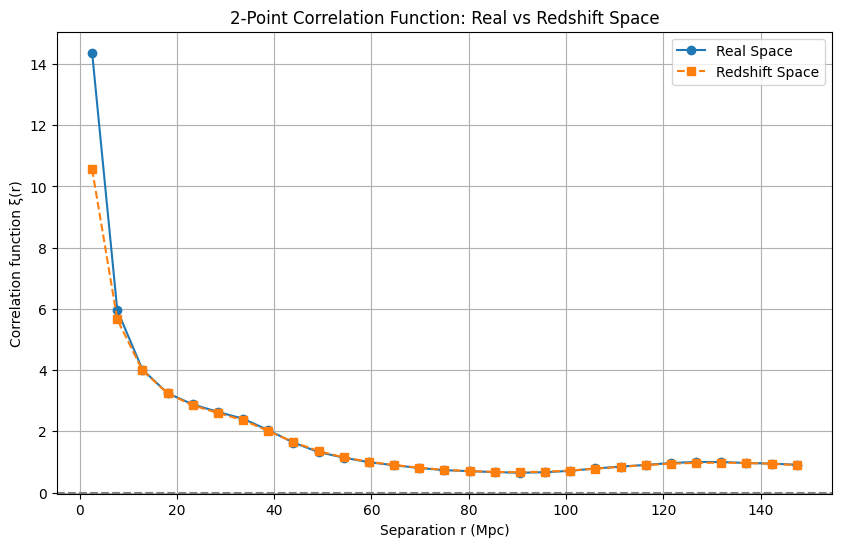

In [8]:
df = pd.read_csv('../data/galaxies_cartesian.csv')
x_rsd, y_rsd, z_rsd = apply_redshift_space_distortions(df)
galaxy_positions_real = df[['x', 'y', 'z_cart']].values
galaxy_positions_rsd = np.column_stack((x_rsd, y_rsd, z_rsd))

x_min, x_max = df['x'].min(), df['x'].max()
y_min, y_max = df['y'].min(), df['y'].max()
z_min, z_max = df['z_cart'].min(), df['z_cart'].max()

num_random = 5 * len(df)
random_positions = np.column_stack((
    np.random.uniform(x_min, x_max, num_random),
    np.random.uniform(y_min, y_max, num_random),
    np.random.uniform(z_min, z_max, num_random)
))

bins = np.linspace(0, 150, 30)
DD_real = count_pairs(galaxy_positions_real, galaxy_positions_real, bins)
RR = count_pairs(random_positions, random_positions, bins)
DR_real = count_pairs(galaxy_positions_real, random_positions, bins)

DD_real = DD_real / (len(galaxy_positions_real) * (len(galaxy_positions_real) - 1) / 2)
RR = RR / (len(random_positions) * (len(random_positions) - 1) / 2)
DR_real = DR_real / (len(galaxy_positions_real) * len(random_positions))

xi_real = (DD_real - 2 * DR_real + RR) / RR
r = 0.5 * (bins[:-1] + bins[1:])

DD_rsd = count_pairs(galaxy_positions_rsd, galaxy_positions_rsd, bins)
DR_rsd = count_pairs(galaxy_positions_rsd, random_positions, bins)

DD_rsd = DD_rsd / (len(galaxy_positions_rsd) * (len(galaxy_positions_rsd) - 1) / 2)
DR_rsd = DR_rsd / (len(galaxy_positions_rsd) * len(random_positions))

xi_rsd = (DD_rsd - 2 * DR_rsd + RR) / RR

plt.figure(figsize=(10, 6))
plt.plot(r, xi_real, marker='o', linestyle='-', label='Real Space')
plt.plot(r, xi_rsd, marker='s', linestyle='--', label='Redshift Space')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Separation r (Mpc)')
plt.ylabel('Correlation function ξ(r)')
plt.title('2-Point Correlation Function: Real vs Redshift Space')
plt.legend()
plt.grid(True)
plt.show()

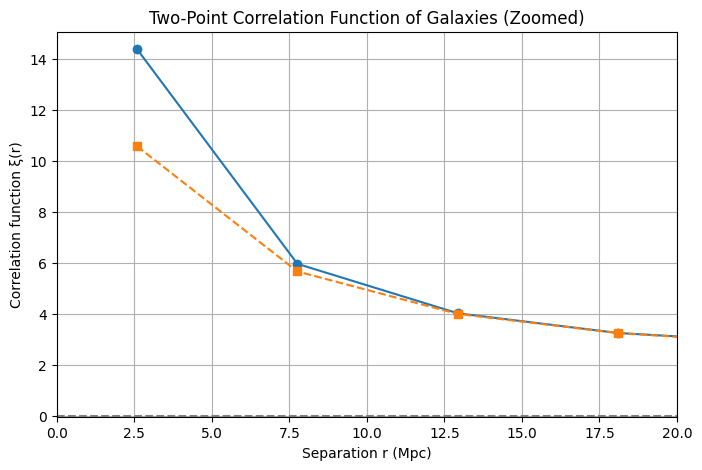

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(r, xi_real, marker='o', linestyle='-', label='Real Space')
plt.plot(r, xi_rsd, marker='s', linestyle='--', label='Redshift Space')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Separation r (Mpc)')
plt.ylabel('Correlation function ξ(r)')
plt.title('Two-Point Correlation Function of Galaxies (Zoomed)')
plt.grid(True)

plt.xlim(0, 20)

plt.show()
